In [2]:
import numpy as np
import os, sys

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set(style='ticks', palette='Set1')

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

# Setup

* To compile and execute this code repo, you need [Snap](http://snap.stanford.edu/snap/index.html), with version 4.1 or later. Be sure to change the address to your Snap directory in Makefile.inc.
* Running RGCR experiment requires a lot of computation, and you are recommend you execute with multithread. You can specify the maximum number of thread to use in utils/meta.h. We recommend using at least 50 threads.

# Data

* Along with this repo, we provides a series of heavy-tailed small-world networks, which are described in the paper. Each network is given as an edgelist in dataset/SWx.txt, where x is the length of the 2D-lattice the network is based on.
* Each network is associated with two files, *-node_meta.txt and *-response.txt.
  * In *-node_meta.txt, we provide some basic meta information of each node, including
    * Node Id
    * d1: node degree
    * d2: 2nd-order degree, defined as |B2(i)|-1
    * clu: local clustering coefficient
    * clo: local closure coefficient
    * n_triad: number of triangles at this node
    * eig1: corresponding element of largest eigenvector of the adjacency matrix $A$
    * eig2: corresponding element of largest eigenvector of $A^2$
  * In *-response.txt, we provide $h_i$ and $e_i$, the homophily and noise term in the response model. For details, see Section 6.2 of the paper.

**TODO: Reproduce Fig 2, the heatmap of homophily and Y_i(0)**

# Variance of HT estimator with mixing $K$ random clusterings

To reproduce Fig 3 on SW32, execute the following commands:

    make
    ./estimate_rgcr_expo_prob -g SW32 -c r_net-3 -w uniform -n 100000
    ./estimate_rgcr_expo_prob -g SW32 -c r_hop_max-1 -w uniform -n 100000

and execute the following cells. Note that each ./estimate_rgcr_expo_prob execution takes ~30 minutes if 50 threads are used in execution.

To reproduce Fig 3 on SW96, each ./estimate_rgcr_expo_prob execution takes ~70 hours.

In [3]:
def parse_file(file_name, values):
    file_input = open(file_name, 'r')
    for line in file_input:
        line = line.strip()
        try:
            # ValueError possibility: str -> float may fail.
            v = float(line)
        except ValueError:
            count_invalid += 1
            print("invalid number in ", filename, ": ln ", count + count_invalid)
            print(line)
            continue
        values.append(v)
    return
    
      
def get_value(result_paths, file_path_name):
    values = []
    for result_path in result_paths:
        parse_file(result_path + file_path_name, values)
    if (len(values) <= 40) :
        lb = min(values)
        ub = max(values)
    else :
        lb = np.quantile(values, 0.025)
        ub = np.quantile(values, 0.975)
    m = np.quantile(values, 0.5)
    return m, lb, ub


def read_variance_all_levels(result_paths, graph_name, method_hop, score, types):
    medians = []
    lbs = []
    ubs = []
    for tp in types:
        file_path_name = graph_name + '/variance/' + method_hop + '-' + score + '-' + tp + '.txt'
        stats = get_value(result_paths, file_path_name)
        medians.append(stats[0])
        lbs.append(stats[1])
        ubs.append(stats[2])
    return medians, lbs, ubs


ind r_net-3 uniform
[573.6579999999999, 56.197649999999996, 14.57165, 4.585430000000001, 4.2554099999999995, 4.23013]
ind r_hop_max-1 uniform
[920596.5, 29920.050000000003, 11.1706, 3.099915, 2.9745600000000003, 2.96164]


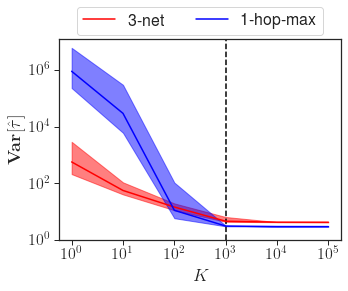

In [9]:
fsz = 18
fig = plt.figure(figsize=(5, 4.3))
ax = fig.gca()
plt.xscale('log')
plt.yscale('log')
ax.axvline(32*32, color='black', linestyle='--')

graph_name = 'SW32'

result_path = 'results/'
randomization = 'ind/'
var_types = ['var_single', 'var_mix10', 'var_mix100', 'var_mix1000', 'var_mix10000', 'var_mix100000']
n_mixings = [10**i for i in range(len(var_types))]
options = [
    [[result_path+randomization], 'r_net-3', 'uniform', 'red'],
    [[result_path+randomization], 'r_hop_max-1', 'uniform', 'b'],
]
for result_paths, method_hop, score, c in options:
    medians, lbs, ubs = read_variance_all_levels(result_paths, graph_name, method_hop, score, var_types)
    print(randomization[:3], method_hop, score)
    print(medians)
    ax.fill_between(n_mixings, ubs, lbs, color=c, alpha=.5)
    legend = '3-net' if method_hop == 'r_net-3' else '1-hop-max'
    ax.plot(n_mixings, medians, color=c, label=legend)


# ax.set_title("Variance at each mixing level", fontsize=fsz)
ax.set_xlabel(r"$K$", fontsize=fsz)
ax.set_ylabel(r'$\mathbf{Var}[\hat{\tau}]$', fontsize=fsz)
ax.set_xticks([1, 10, 1e2, 1e3, 1e4, 1e5])
ax.set_yticks(np.array([1, 10**2, 10**4, 10**6], dtype=np.float))
ax.xaxis.set_tick_params(which='major', width=1, size=5)
ax.xaxis.set_tick_params(which='minor', width=0, size=0)
ax.yaxis.set_tick_params(which='major', width=1, size=5)
ax.yaxis.set_tick_params(which='minor', width=0, size=0)
plt.setp(ax.get_xticklabels(), fontsize=fsz-2)
plt.setp(ax.get_yticklabels(), fontsize=fsz-2)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, fontsize=fsz-2, ncol=2)
fig.tight_layout()
# fig.savefig('fig/GCR-HT-SW96.pdf')
plt.show()

# Estimate exposure probabilities

To estimate the exposure probabilities with stratified MC sampling, use command

    ./estimate_rgcr_expo_prob -g SW32 -c r_net-3 -w uniform -s -n 128 [-t]

For details see usage_msg in estimate_rgcr_expo_prob.cpp

# Compute variance of HT estimator under RGCR

To reproduce Fig 7 on SW32, first execute the following commands

    ./estimate_rgcr_expo_prob -g SW32 -c [method] -w [weight] -s -n 128
    ./estimate_rgcr_expo_prob -g SW32 -c [method] -w [weight] -s -n 128 -t
    
for [method] in {r_net-3, r_hop_max-1} and [weight] in {uniform, d1, eig2}.
Each command takes ~30 minutes to execute.

Then execute the following commands:

    ./compute_rgcr_variance -g SW32 -c [method]-[weight] -s mix128n-0.txt -m -o SW32
    ./compute_rgcr_variance -g SW32 -c [method]-[weight] -s mix128n-0.txt -m -o SW32 -r

again for [method] in {r_net-3, r_hop_max-1} and [weight] in {uniform, d1, eig2}.
Each command takes ~5 seconds to execute.

After completing all the commands above, execute the following cells.

In [10]:
def read_variance_formula(filename, n_lines, path=''):
    fin = open(path+filename, 'r')
    results = []
    for i in range(n_lines):
        next(fin)
        results.append([float(s) for s in fin.readline().strip().split()])
    return np.array(results)

In [11]:
x = np.array([1, 5, 10, 14])
width = 1
weights = ['uniform', 'spectral', 'degree']
labels = [
    '3-net--ind',
    '3-net--com',
    '1-hop-max--ind',
    '1-hop-max--com',
]
indices = np.array([0, 6, 3, 9])


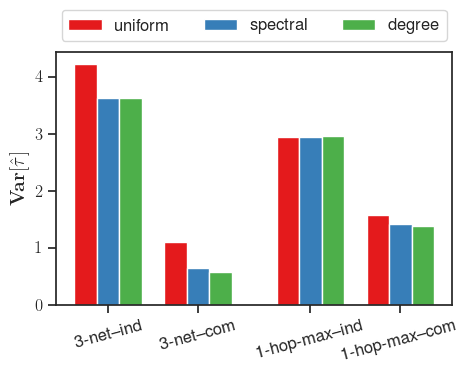

In [14]:
variance_HT = read_variance_formula('results/variances-HT-SW32.txt', 12)[:, 0]
fsz = 12
fig = plt.figure(figsize=(5, 4), dpi=100)
ax = fig.gca()
for i in range(3):
    result_i = variance_HT[i+indices]
    ax.bar(x+i, result_i, width, label=weights[i])

ax.set_ylabel(r'$\mathbf{Var}[\hat{\tau}]$', fontsize=fsz+2)
plt.setp(ax.get_yticklabels(), fontsize=fsz)
# ax.set_title('Variance of HT estimator')
ax.set_xticks(x+1)
ax.set_xticklabels(labels, rotation=15, fontsize=fsz)
# ax.legend(fontsize=fsz, loc=(0.24,0.67))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, fontsize=fsz, ncol=3)
fig.tight_layout()
# fig.savefig('fig/RGCR-HT-SW96.pdf')
plt.show()


# Simulate bias/variance/MSE of Hajek-estimator under RGCR

To reproduce Fig 9 on SW32, first make sure the commands in the above section is completed, and then execute the following commands:

    ./simulate_rgcr_variance -g SW32 -c [method] -w [weight] -s mix128n-0.txt -h Hajek -m -n 50 -o SW32
    ./simulate_rgcr_variance -g SW32 -c [method] -w [weight] -s mix128n-0.txt -h Hajek -m -n 50 -o SW32 -r

for [method] in {r_net-3, r_hop_max-1} and [weight] in {uniform, d1, eig2}.
Each command takes ~1 minute to execute.

After completing all the commands above, execute the following cells.

In [15]:
def read_variance_simulation(filename, n_lines, path=''):
    fin = open(path+filename, 'r')
    results = []
    for i in range(n_lines):
        next(fin)
        next(fin)
        results.append([float(s) for s in fin.readline().strip().split()])
    return np.array(results)

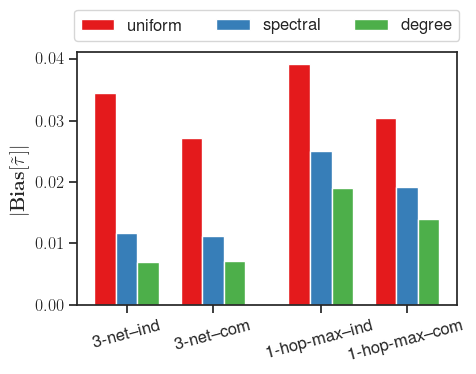

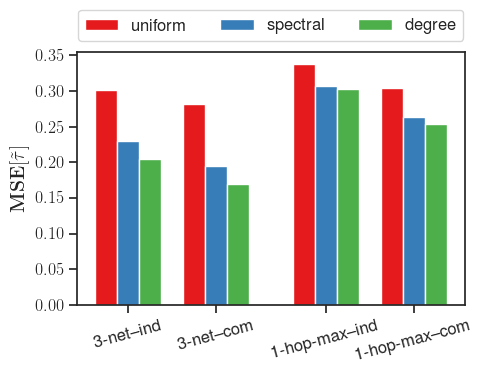

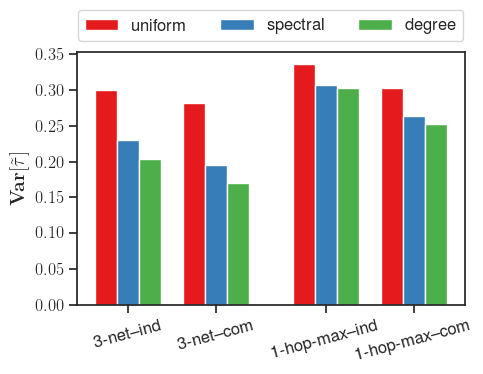

In [17]:
results = read_variance_simulation('results/simulation-Hajek-SW32.txt', 12)
fsz = 12

fig = plt.figure(figsize=(5, 4), dpi=100)
ax = fig.gca()
for i in range(3):
    bias_i = results[i+indices, 0]
    ax.bar(x+i, np.abs(bias_i), width, label=weights[i])
ax.set_ylabel(r'$|\mathbf{Bias}[\tilde{\tau}]|$', fontsize=fsz+2)
plt.setp(ax.get_yticklabels(), fontsize=fsz)
ax.set_xticks(x+1)
ax.set_xticklabels(labels, rotation=15, fontsize=fsz)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, fontsize=fsz, ncol=3)
fig.tight_layout()
# fig.savefig('fig/RGCR-Hajek-Bias-SW96.pdf')
plt.show()

fig = plt.figure(figsize=(5, 4), dpi=100)
ax = fig.gca()
for i in range(3):
    bias_i = results[i+indices, 2]
    ax.bar(x+i, bias_i, width, label=weights[i])
ax.set_ylabel(r'$\mathbf{MSE}[\tilde{\tau}]$', fontsize=fsz+2)
plt.setp(ax.get_yticklabels(), fontsize=fsz)
ax.set_xticks(x+1)
ax.set_xticklabels(labels, rotation=15, fontsize=fsz)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, fontsize=fsz, ncol=3)
fig.tight_layout()
# fig.savefig('fig/RGCR-Hajek-MSE-SW96.pdf')
plt.show()

fig = plt.figure(figsize=(5, 4), dpi=100)
ax = fig.gca()
for i in range(3):
    bias_i = results[i+indices, 2] - results[i+indices, 0] * results[i+indices, 0]
    ax.bar(x+i, bias_i, width, label=weights[i])
ax.set_ylabel(r'$\mathbf{Var}[\tilde{\tau}]$', fontsize=fsz+2)
plt.setp(ax.get_yticklabels(), fontsize=fsz)
ax.set_xticks(x+1)
ax.set_xticklabels(labels, rotation=15, fontsize=fsz)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, fontsize=fsz, ncol=3)
fig.tight_layout()
# fig.savefig('fig/RGCR-Hajek-Var-SW96.pdf')
plt.show()

# Uncleaned stuffs below

# Bias and MSE reduction in Hajek estimation

In [17]:
def read_gcr_simulation_median(graph_name, method, path=''):
    if method:
        filename = path + 'simulation-GCR-Hajek-{}-{}.txt'.format(graph_name, method)
    else:
        filename = path + 'simulation-GCR-Hajek-{}.txt'.format(graph_name)
    results_gcr = np.loadtxt(filename, skiprows=2, max_rows=1000)
    bias = np.quantile(results_gcr[:,0], 0.5)
    mse = np.quantile(results_gcr[:,2], 0.5)
    fin = open(filename, 'r')
    next(fin)
    GATE_gt = float(fin.readline()[7:])
    return bias, mse, GATE_gt


In [18]:
def read_gcr_weights(graph_name):
    bias_gcr = []
    mse_gcr = []
    gate_gt = []
    for w in ['uniform', 'eig2', 'd1']:
        bias, mse, GATE_gt = read_gcr_simulation_median(graph_name, w)
        bias_gcr.append(bias)
        mse_gcr.append(mse)
        gate_gt.append(GATE_gt)
    return np.array(bias_gcr), np.array(mse_gcr), np.array(gate_gt)


In [19]:
x = np.array([1, 4, 7])
width = 1
weights = ['uniform', 'spectral', 'degree']
labels = [
    '3-net-uniform',
    '3-net-spectral',
    '3-net-degree',
]

labels_sim = [s[6:] for s in labels]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


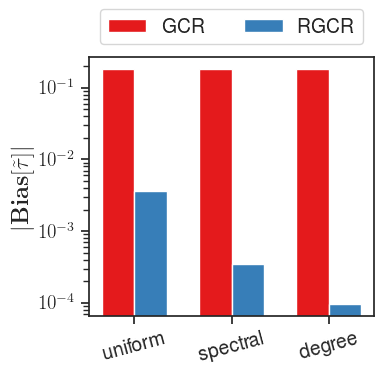

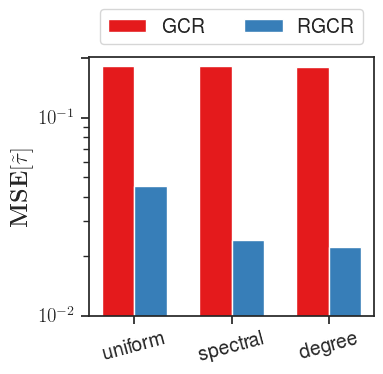

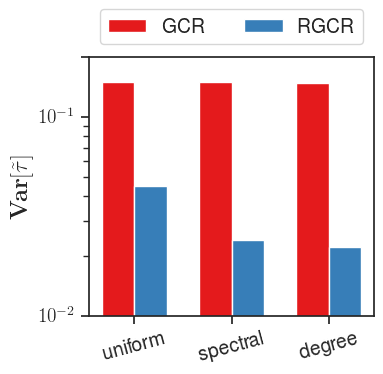

In [20]:
graph_name = "SW96"
gcr_results = read_gcr_weights(graph_name)
rgcr_results = read_variance_simulation('simulation-Hajek-{}.txt'.format(graph_name), 3)


fsz = 14

fig = plt.figure(figsize=(4, 4), dpi=100)
ax = fig.gca()
ax.bar(x, np.abs(gcr_results[0]), width, label='GCR')
ax.bar(x+1, np.abs(rgcr_results[:,0]), width, label='RGCR')
ax.set_ylabel(r'$|\mathbf{Bias}[\tilde{\tau}]|$', fontsize=fsz+3)
plt.setp(ax.get_yticklabels(), fontsize=fsz)
ax.set_xticks(x+0.5)
ax.set_xticklabels(labels_sim, rotation=15, fontsize=fsz)
ax.set_yscale('log')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22), fancybox=True, fontsize=fsz, ncol=3)
fig.tight_layout()
fig.savefig('fig/GCR-Hajek-Bias-{}.pdf'.format(graph_name))
plt.show()

fig = plt.figure(figsize=(4, 4), dpi=100)
ax = fig.gca()
ax.bar(x, gcr_results[1], width, label='GCR')
ax.bar(x+1, rgcr_results[:,2], width, label='RGCR')
ax.set_ylabel(r'$\mathbf{MSE}[\tilde{\tau}]$', fontsize=fsz+3)
plt.setp(ax.get_yticklabels(), fontsize=fsz)
ax.set_xticks(x+0.5)
ax.set_xticklabels(labels_sim, rotation=15, fontsize=fsz)
ax.set_yscale('log')
ax.set_yticks([0.01, 0.1, 0.2])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22), fancybox=True, fontsize=fsz, ncol=3)
fig.tight_layout()
fig.savefig('fig/GCR-Hajek-MSE-{}.pdf'.format(graph_name))
plt.show()

fig = plt.figure(figsize=(4, 4), dpi=100)
ax = fig.gca()
ax.bar(x, gcr_results[1] - gcr_results[0] * gcr_results[0], width, label='GCR')
ax.bar(x+1, rgcr_results[:,2] - rgcr_results[:,0] * rgcr_results[:,0], width, label='RGCR')
ax.set_ylabel(r'$\mathbf{Var}[\tilde{\tau}]$', fontsize=fsz+3)
plt.setp(ax.get_yticklabels(), fontsize=fsz)
ax.set_xticks(x+0.5)
ax.set_xticklabels(labels_sim, rotation=15, fontsize=fsz)
ax.set_yscale('log')
ax.set_yticks([0.01, 0.1, 0.2])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22), fancybox=True, fontsize=fsz, ncol=3)
fig.tight_layout()
fig.savefig('fig/GCR-Hajek-Var-{}.pdf'.format(graph_name))
plt.show()

# fig = plt.figure(figsize=(4, 4), dpi=100)
# ax = fig.gca()
# ax.bar(x, (gcr_results[1] - gcr_results[0] * gcr_results[0]) / (gcr_results[2] + gcr_results[0])/(gcr_results[2] + gcr_results[0]), width, label='GCR')
# ax.bar(x+1, (rgcr_results[:,2] - rgcr_results[:,0] * rgcr_results[:,0]) / (gcr_results[2] + rgcr_results[:,0])/(gcr_results[2] + rgcr_results[:,0]), width, label='RGCR')
# ax.set_ylabel(r'Scaled $\mathbf{Var}[\tilde{\tau}]$', fontsize=fsz+3)
# plt.setp(ax.get_yticklabels(), fontsize=fsz)
# ax.set_xticks(x+0.5)
# ax.set_xticklabels(labels_sim, rotation=15, fontsize=fsz)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22), fancybox=True, fontsize=fsz, ncol=3)
# fig.tight_layout()
# fig.savefig('fig/GCR-Hajek-ScaVar-{}.pdf'.format(graph_name))
# plt.show()

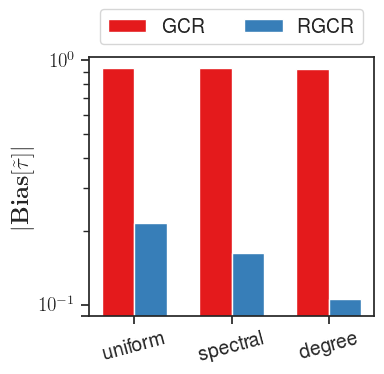

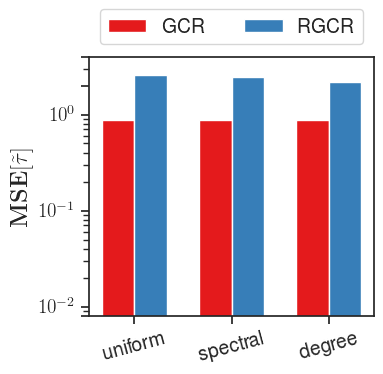

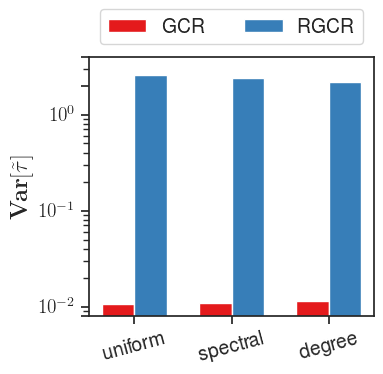

In [21]:
graph_name = "Stanford"
gcr_results = read_gcr_weights(graph_name)
rgcr_results = read_variance_simulation('simulation-Hajek-{}.txt'.format(graph_name), 3)


fsz = 14

fig = plt.figure(figsize=(4, 4), dpi=100)
ax = fig.gca()
ax.bar(x, np.abs(gcr_results[0]), width, label='GCR')
ax.bar(x+1, np.abs(rgcr_results[:,0]), width, label='RGCR')
ax.set_ylabel(r'$|\mathbf{Bias}[\tilde{\tau}]|$', fontsize=fsz+3)
plt.setp(ax.get_yticklabels(), fontsize=fsz)
ax.set_xticks(x+0.5)
ax.set_xticklabels(labels_sim, rotation=15, fontsize=fsz)
ax.set_yscale('log')
ax.set_yticks([0.09, 0.1, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22), fancybox=True, fontsize=fsz, ncol=3)
fig.tight_layout()
fig.savefig('fig/GCR-Hajek-Bias-{}.pdf'.format(graph_name))
plt.show()

fig = plt.figure(figsize=(4, 4), dpi=100)
ax = fig.gca()
ax.bar(x, gcr_results[1], width, label='GCR')
ax.bar(x+1, rgcr_results[:,2], width, label='RGCR')
ax.set_ylabel(r'$\mathbf{MSE}[\tilde{\tau}]$', fontsize=fsz+3)
plt.setp(ax.get_yticklabels(), fontsize=fsz)
ax.set_xticks(x+0.5)
ax.set_xticklabels(labels_sim, rotation=15, fontsize=fsz)
ax.set_yscale('log')
ax.set_yticks([0.008, 0.01, 0.1, 1, 2, 4])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22), fancybox=True, fontsize=fsz, ncol=3)
fig.tight_layout()
fig.savefig('fig/GCR-Hajek-MSE-{}.pdf'.format(graph_name))
plt.show()

fig = plt.figure(figsize=(4, 4), dpi=100)
ax = fig.gca()
ax.bar(x, gcr_results[1] - gcr_results[0] * gcr_results[0], width, label='GCR')
ax.bar(x+1, rgcr_results[:,2] - rgcr_results[:,0] * rgcr_results[:,0], width, label='RGCR')
ax.set_ylabel(r'$\mathbf{Var}[\tilde{\tau}]$', fontsize=fsz+3)
plt.setp(ax.get_yticklabels(), fontsize=fsz)
ax.set_xticks(x+0.5)
ax.set_xticklabels(labels_sim, rotation=15, fontsize=fsz)
ax.set_yscale('log')
ax.set_yticks([0.008, 0.01, 0.1, 1, 2, 4])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22), fancybox=True, fontsize=fsz, ncol=3)
fig.tight_layout()
fig.savefig('fig/GCR-Hajek-Var-{}.pdf'.format(graph_name))
plt.show()

# fig = plt.figure(figsize=(4, 4), dpi=100)
# ax = fig.gca()
# ax.bar(x, (gcr_results[1] - gcr_results[0] * gcr_results[0]) / (gcr_results[2] + gcr_results[0])/(gcr_results[2] + gcr_results[0]), width, label='GCR')
# ax.bar(x+1, (rgcr_results[:,2] - rgcr_results[:,0] * rgcr_results[:,0]) / (gcr_results[2] + rgcr_results[:,0])/(gcr_results[2] + rgcr_results[:,0]), width, label='RGCR')
# ax.set_ylabel(r'Scaled $\mathbf{Var}[\tilde{\tau}]$', fontsize=fsz+3)
# plt.setp(ax.get_yticklabels(), fontsize=fsz)
# ax.set_xticks(x+0.5)
# ax.set_xticklabels(labels_sim, rotation=15, fontsize=fsz)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22), fancybox=True, fontsize=fsz, ncol=3)
# fig.tight_layout()
# fig.savefig('fig/GCR-Hajek-ScaVar-{}.pdf'.format(graph_name))
# plt.show()

In [22]:
def read_gcr_graphs(graph_names, method, path=''):
    bias_gcr = []
    mse_gcr = []
    gate_gt = []
    for graph_name in graph_names:
        bias, mse, GATE_gt = read_gcr_simulation_median(graph_name, method, path)
        bias_gcr.append(bias)
        mse_gcr.append(mse)
        gate_gt.append(GATE_gt)
    return np.array(bias_gcr), np.array(mse_gcr)#, np.array(gate_gt)


In [23]:
graph_names = [
    'SW16',
    'SW24',
    'SW32',
    'SW48',
    'SW64',
    'SW96',
]

L = np.array([int(s[2:]) for s in graph_names])

n = L ** 2

m = np.array([
	1597,
	3452,
	6139,
	13626,
	24713,
	55214,
])

print(2 * m / n)

[12.4765625  11.98611111 11.99023438 11.828125   12.06689453 11.98220486]


In [24]:
method = 'uniform'
# method = 'eig2'

bias_gcr, mse_gcr = read_gcr_graphs(graph_names, method)
print(bias_gcr)
print(mse_gcr)

results_rgcr = read_variance_simulation('simulation-Hajek-SWx.txt', 6)
print(results_rgcr[:,0])
print(results_rgcr[:,2])

[-0.301395  -0.255585  -0.2628925 -0.2197905 -0.2159245 -0.184855 ]
[0.305235  0.2483025 0.2760605 0.2303915 0.209246  0.183087 ]
[-0.156825   -0.065317   -0.0371719  -0.0142935  -0.00797139 -0.00342273]
[0.459658  0.368846  0.294847  0.15015   0.0888725 0.0451322]


In [25]:
variance_HT = read_variance_formula('variances-HT-SWx.txt', 6)[:, 2]
print(variance_HT)

[30.5441    9.95328   4.22957   1.42903   0.745507  0.310246]


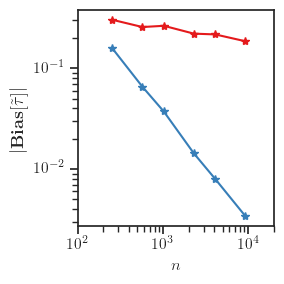

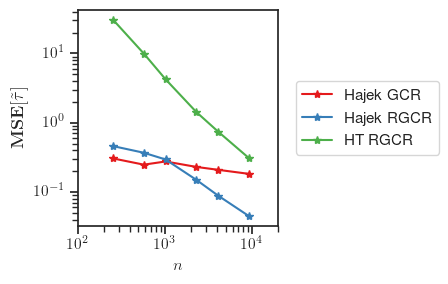

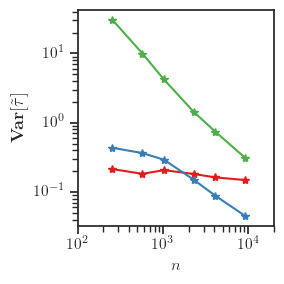

In [28]:
fsz = 11

fig = plt.figure(figsize=(3, 3), dpi=100)
ax = plt.gca()
ax.plot(n, -bias_gcr, '*-', label='Hajek GCR')
ax.plot(n, -results_rgcr[:,0], '*-', label='Hajek RGCR')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$n$')
ax.set_ylabel(r'$|\mathbf{Bias}[\tilde{\tau}]|$', fontsize=fsz+2)
ax.set_xlim(100, 20000)
plt.xticks([100, 1000, 10000])
# plt.setp(ax.get_yticklabels(), fontsize=fsz)
# ax.legend(loc='lower left', fontsize=fsz)
fig.tight_layout()
fig.savefig('fig/GCR-Hajek-Bias-SWx.pdf')
plt.show()

fig = plt.figure(figsize=(4.73, 3), dpi=100)
ax = plt.gca()
ax.plot(n, mse_gcr, '*-', label='Hajek GCR')
ax.plot(n, results_rgcr[:,2], '*-', label='Hajek RGCR')
ax.plot(n, variance_HT, '*-', label='HT RGCR')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$n$')
ax.set_ylabel(r'$\mathbf{MSE}[\tilde{\tau}]$', fontsize=fsz+2)
ax.set_xlim(100, 20000)
plt.xticks([100, 1000, 10000])
# plt.setp(ax.get_yticklabels(), fontsize=fsz)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=fsz)
fig.tight_layout()
fig.savefig('fig/GCR-Hajek-MSE-SWx.pdf')
plt.show()

fig = plt.figure(figsize=(3, 3), dpi=100)
ax = plt.gca()
ax.plot(n, mse_gcr - bias_gcr * bias_gcr, '*-', label='Hajek GCR')
ax.plot(n, results_rgcr[:,2] - results_rgcr[:,0] * results_rgcr[:,0], '*-', label='Hajek RGCR')
ax.plot(n, variance_HT, '*-', label='HT RGCR')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$n$')
ax.set_ylabel(r'$\mathbf{Var}[\tilde{\tau}]$', fontsize=fsz+2)
ax.set_xlim(100, 20000)
plt.xticks([100, 1000, 10000])
# plt.setp(ax.get_yticklabels(), fontsize=fsz)
# ax.legend(loc='lower left', fontsize=fsz)
fig.tight_layout()
fig.savefig('fig/GCR-Hajek-Var-SWx.pdf')
plt.show()


In [63]:
school_names = [
    'Caltech36',
    'Swarthmore42',
    'Trinity100',
    'Rice31',
    'UChicago30',
    'Yale4',
    'Stanford3',
    'UMass92',
    'Wisconsin87',
]

n = [
    762,
    1657,
    2613,
    4083,
    6561,
    8561,
    11586,
    16502,
    23831,
]

In [70]:
bias_gcr, mse_gcr = read_gcr_graphs(school_names, "", 'fb100/')


In [74]:
results_rgcr = read_variance_simulation('simulation-Hajek-fb100.txt', 9, 'fb100/')
print(results_rgcr[:,0])
print(results_rgcr[:,2])

[-0.448626  -0.389583  -0.258243  -0.275991  -0.197783  -0.221115
 -0.215909  -0.103621  -0.0983914]
[2.11531 2.43499 1.795   2.41048 2.28675 2.27672 2.60138 1.47365 1.6996 ]


In [75]:
variance_HT = read_variance_formula('variances-HT.txt', 9, 'fb100/')[:, 2]
print(variance_HT)

[ 57.5733  135.045    24.258    12.0422    9.82913   9.8035    9.11815
   6.64513   7.23235]


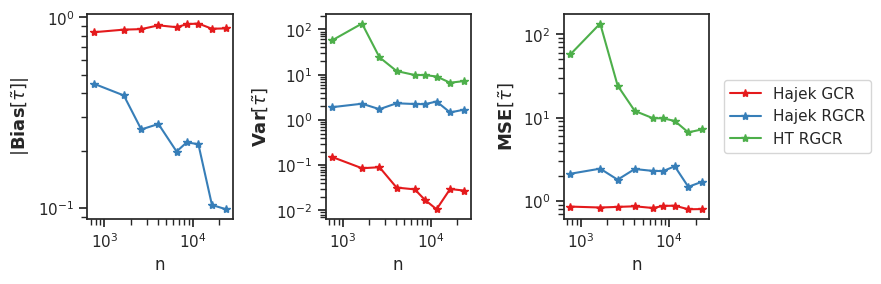

In [83]:
fsz = 11

widths = [3,3,3]
fig = plt.figure(figsize=(sum(widths), 3), dpi=100)
gs = GridSpec(1,3, width_ratios=widths)


ax = plt.subplot(gs[0,0])
ax.plot(n, -bias_gcr, '*-', label='Hajek GCR')
ax.plot(n, -results_rgcr[:,0], '*-', label='Hajek RGCR')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('n')
ax.set_ylabel(r'$|\mathbf{Bias}[\tilde{\tau}]|$', fontsize=fsz+2)
# ax.set_xlim(100, 20000)
# plt.xticks([100, 1000, 10000])
# plt.setp(ax.get_yticklabels(), fontsize=fsz)
# ax.legend(loc='lower left', fontsize=fsz)
# fig.tight_layout()
# fig.savefig('fig/GCR-Hajek-Bias-fb100.pdf')
# plt.show()

# fig = plt.figure(figsize=(4.73, 3), dpi=100)
# ax = plt.gca()
ax = plt.subplot(gs[0,2])
ax.plot(n, mse_gcr, '*-', label='Hajek GCR')
ax.plot(n, results_rgcr[:,2], '*-', label='Hajek RGCR')
ax.plot(n, variance_HT, '*-', label='HT RGCR')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('n')
ax.set_ylabel(r'$\mathbf{MSE}[\tilde{\tau}]$', fontsize=fsz+2)
# ax.set_xlim(100, 20000)
# plt.xticks([100, 1000, 10000])
# plt.setp(ax.get_yticklabels(), fontsize=fsz)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=fsz)
# fig.tight_layout()
# fig.savefig('fig/GCR-Hajek-MSE-fb100.pdf')
# plt.show()

# fig = plt.figure(figsize=(3, 3), dpi=100)
# ax = plt.gca()
ax = plt.subplot(gs[0,1])
ax.plot(n, mse_gcr - bias_gcr * bias_gcr, '*-', label='Hajek GCR')
ax.plot(n, results_rgcr[:,2] - results_rgcr[:,0] * results_rgcr[:,0], '*-', label='Hajek RGCR')
ax.plot(n, variance_HT, '*-', label='HT RGCR')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('n')
ax.set_ylabel(r'$\mathbf{Var}[\tilde{\tau}]$', fontsize=fsz+2)
# ax.set_xlim(100, 20000)
# plt.xticks([100, 1000, 10000])
# plt.setp(ax.get_yticklabels(), fontsize=fsz)
# ax.legend(loc='lower left', fontsize=fsz)

fig.tight_layout()
fig.savefig('fig/GCR-Hajek-all-fb100.pdf')
plt.show()


# Variance vs the network drift effect significance $b$

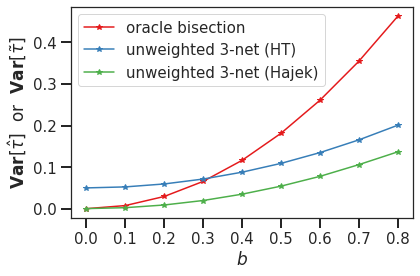

In [17]:
K = 9
variance_HT = read_variance_formula('variances-HT-b.txt', 2*K)[:, 2]
variance_Hajek = read_variance_simulation('simulation-Hajek-b.txt', K)[:,2]

bs = [0.1 * k for k in range(K)]

fsz = 15

fig = plt.figure()
ax = fig.gca()
ax.plot(bs[:K], variance_HT[:K], '*-', label='oracle bisection')
ax.plot(bs[:K], variance_HT[K:(2*K)], '*-', label='unweighted 3-net (HT)')
ax.plot(bs[:K], variance_Hajek[:K], '*-', label='unweighted 3-net (Hajek)')

ax.set_xlabel(r'$b$', fontsize=fsz+2)
# ax.set_ylabel(r'$\mathbf{Var}[\hat{\tau}]$', fontsize=fsz+2)
ax.set_ylabel(r'$\mathbf{Var}[\hat{\tau}]$  or  $\mathbf{Var}[\tilde{\tau}]$', fontsize=fsz+2)
ax.legend(loc='best', fontsize=fsz) # loc can also be 'upper right' or (0.1, 1.05)

ax.xaxis.set_tick_params(which='major', width=2, size=10)
ax.xaxis.set_tick_params(which='minor', width=1, size=4)
ax.yaxis.set_tick_params(which='major', width=2, size=10)
ax.yaxis.set_tick_params(which='minor', width=1, size=4)
# ax.grid()
plt.setp(ax.get_xticklabels(), fontsize=fsz)  ## setp means 'set property'
plt.setp(ax.get_yticklabels(), fontsize=fsz)

""" A helper function to fit everything into fig """
fig.tight_layout()
fig.savefig('fig/var-b.pdf')
plt.show()

# Variance of HT with 2-net (maximal independent set clustering)

In [104]:
indices = np.arange(0, 30, 3)
print(indices)
x = np.arange(1, 21, 4)
x = np.array(list(x) + list(x+22))
print(x)

width = 1
weights = ['uniform', 'spectral', 'degree']
labels = [
    '2-rand--ind',
    '2-first--ind',
    '2-small--ind',
    '2-large--ind',
    '3-rand--ind',
    '2-rand--tot',
    '2-first--tot',
    '2-small--tot',
    '2-large--tot',
    '3-rand--tot',
]

[ 0  3  6  9 12 15 18 21 24 27]
[ 1  5  9 13 17 23 27 31 35 39]


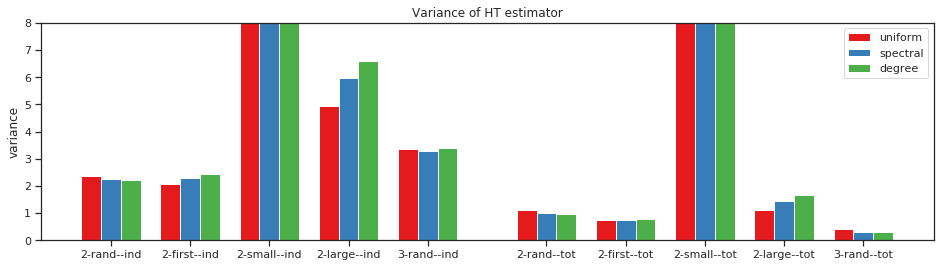

In [106]:
results = read_variance_eval('variances-HT-SW_1PL_2net.txt',30)
fig = plt.figure(figsize=(16, 4))
ax = fig.gca()
for i in range(3):
    result_i = results[i+indices, 2]
    ax.bar(x+i, result_i, width, label=weights[i])

ax.set_ylabel('variance')
ax.set_title('Variance of HT estimator')
ax.set_xticks(x+1)
ax.set_xticklabels(labels)
# ax.set_yscale('log')
ax.set_ylim([0, 8])
ax.legend()
plt.show()